In [4]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import pickle
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import warnings
warnings.filterwarnings('ignore')

In [5]:
input_shape = (224, 224, 3)
num_classes = 5
train_dataset_dir = "Dataset/Animals"

# Data augmentation and generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    zoom_range=0.3,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    subset='validation'
)

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [6]:
# Load pre-trained InceptionV3 model and build custom model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy', tf.keras.metrics.Recall()]
)

# Checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'inception_model.keras',
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [7]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Reduced number of epochs
    callbacks=[model_checkpoint]
)

# Save the trained model
model.save("DLModel.h5")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.1949 - loss: 2.9994 - recall: 0.1397
Epoch 1: val_categorical_accuracy improved from -inf to 0.33500, saving model to inception_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - categorical_accuracy: 0.1955 - loss: 2.9915 - recall: 0.1393 - val_categorical_accuracy: 0.3350 - val_loss: 1.5643 - val_recall: 0.0000e+00
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2493 - loss: 1.9367 - recall: 0.1025
Epoch 2: val_categorical_accuracy improved from 0.33500 to 0.65500, saving model to inception_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - categorical_accuracy: 0.2496 - loss: 1.9323 - recall: 0.1019 - val_categorical_accuracy: 0.6550 - val_loss: 1.4988 - val_recall: 0.0000e+00
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2498 - loss: 1.6425 - recall: 0.0623
Epoch 3: val_categorical_accuracy did not improve from 0.65500
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s

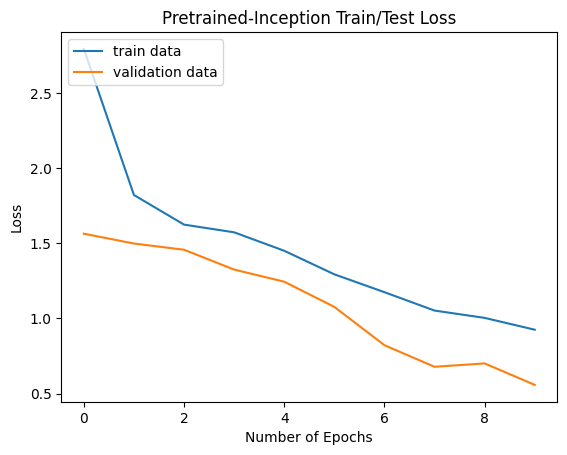

In [8]:
plt.plot(history.history['loss'], label='train data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Pretrained-Inception Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('Pretrained-InceptionV3-relu-loss-Graph.png', bbox_inches='tight')
plt.show()

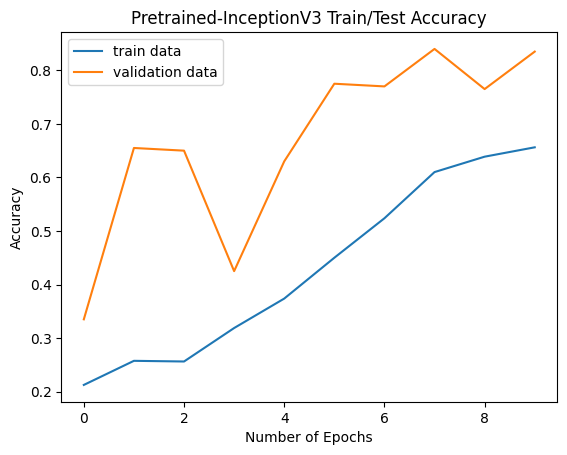

In [9]:
plt.plot(history.history['categorical_accuracy'], label='train data')
plt.plot(history.history['val_categorical_accuracy'], label='validation data')
plt.title('Pretrained-InceptionV3 Train/Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('InceptionV3-relu-Accuracy-Graph.png', bbox_inches='tight')
plt.show()

In [11]:
# Feature extraction function
def extract_feature(img_path, model):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image: {img_path}")
        return None
    img = cv2.resize(img, (224, 224))
    img = np.array(img)
    expand_img = np.expand_dims(img, axis=0)
    pre_img = preprocess_input(expand_img)
    result = model.predict(pre_img).flatten()
    normalized = result / np.linalg.norm(result)
    return normalized

# Extract features for the dataset
directory = 'Dataset'
file_paths = [os.path.join(root, filename) for root, _, filenames in os.walk(directory) for filename in filenames]

# Initialize the feature list and filter out failed extractions
feature_list = []
valid_file_paths = []

for file in file_paths:
    feature = extract_feature(file, model)
    if feature is not None:
        feature_list.append(feature)
        valid_file_paths.append(file)

# Save features and file paths
with open('feature_list.pkl', 'wb') as f:
    pickle.dump(feature_list, f)
with open('file_paths.pkl', 'wb') as f:
    pickle.dump(valid_file_paths, f)

Failed to read image: Dataset\Animals\animals.ods
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/st

In [12]:
# Train Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=5, algorithm="brute", metric="euclidean")
neighbors.fit(feature_list)

# Save the Nearest Neighbors model
with open('neighbors_model.pkl', 'wb') as f:
    pickle.dump(neighbors, f)